The Jupyter notebook titled [ts_model_darts.ipynb](file:///Users/jespervang/Projects/MTX/MTX_timeseries_v2/ts_model_darts.ipynb#1%2C1-1%2C1) appears to be focused on time series analysis and preprocessing using the Darts library, which is designed for easy manipulation and forecasting of time series. Here's a breakdown of the key sections and operations performed in the notebook:

### Setup and Configuration
- **Imports**: Libraries such as [pandas](file:///Users/jespervang/Projects/MTX/MTX_timeseries_v2/ts_model_darts.ipynb#10%2C8-10%2C8), [numpy](file:///Users/jespervang/Projects/MTX/MTX_timeseries_v2/ts_model_darts.ipynb#9%2C8-9%2C8), [matplotlib](file:///Users/jespervang/Projects/MTX/MTX_timeseries_v2/ts_model_darts.ipynb#8%2C8-8%2C8), [torch](file:///Users/jespervang/Projects/MTX/MTX_timeseries_v2/ts_model_darts.ipynb#11%2C8-11%2C8), and several modules from [darts](file:///Users/jespervang/Projects/MTX/MTX_timeseries_v2/ts_model_darts.ipynb#12%2C6-12%2C6) are imported.
- **Logging and Warnings**: Configurations to suppress warnings and control logging levels are set up.
- **Matplotlib Settings**: Default figure size for plots is set.

### Data Loading and Preprocessing
- **Data Loading**: A CSV file is loaded into a pandas DataFrame.
- **Data Manipulation**:
  - Unique patient identifiers are counted.
  - Data is grouped by patient and component, and the last data point for each group is removed.
  - Anonymization of patient IDs is performed by replacing digits with letters.
  - Unique component names are extracted and printed.
  
### Advanced Data Transformation
- **Logging Configuration**: Reconfiguration of logging to output to standard output.
- **Data Transformation**:
  - Mean age at sample for each patient is calculated and merged back into the DataFrame.
  - A static DataFrame ([df_static](file:///Users/jespervang/Projects/MTX/MTX_timeseries_v2/ts_model_darts.ipynb#112%2C28-112%2C28)) is created containing unique IDs and static features like age and sex.
  - Several columns are dropped from the main DataFrame.

### Time Series Preprocessing
- **Custom Class Definition**: A class [TimeSeriesPreprocessor](file:///Users/jespervang/Projects/MTX/MTX_timeseries_v2/ts_model_darts.ipynb#139%2C7-139%2C7) is defined to handle various preprocessing steps such as normalization of time, handling missing values, and applying decay functions to model temporal effects.
- **Data Processing**: The DataFrame is processed using the defined class to handle missing values, encode temporal distances, and apply decay based on the model parameters estimated.

### Visualization and Testing
- **Visualization**: Plots are generated to compare patient data before and after transformation.
- **Testing**: Functions are defined and executed to test the effectiveness of decay application and the handling of missing values.

### Data Transformation and Analysis
- **Further Data Manipulation**: The DataFrame is transformed to include a new index and various checks and transformations are applied to ensure data integrity and prepare for modeling.
- **Model Preparation**: Data is split into training, validation, and test sets. TimeSeries objects are created for each set using Darts' functionality, which includes handling of static covariates.

### Modeling and Forecasting
- **Model Configuration and Training**: Placeholder comments suggest the setup for model training using PyTorch Lightning and Darts, including hyperparameter tuning and early stopping configurations.

### Conclusion
The notebook is a comprehensive example of handling, preprocessing, and modeling time series data in a medical context, with a focus on robust data manipulation techniques and advanced time series modeling using the Darts library.

In [1]:
# import pkg_resources
import logging
import shutil
import warnings

import lightning.pytorch as pl
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import torch
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers.scaler import Scaler
from darts.datasets import AirPassengersDataset
from darts.metrics import mae, mape, mse  #smape
from darts.models import TFTModel, TiDEModel
from darts.utils.callbacks import TFMProgressBar
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from lightning.pytorch import Trainer
from optuna.integration.pytorch_lightning import PyTorchLightningPruningCallback
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm, trange

# from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)


class OptunaPruning(PyTorchLightningPruningCallback, pl.Callback):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)


# set a consant figure size
plt.rcParams["figure.figsize"] = (32, 5)  # set default size of plots
fig_size = (32, 5)  # wide figures

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch23/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%load_ext autoreload 
# Reload all modules every time before executing the Python code typed.
%autoreload 2 
# Visualizations will be displayed in the notebook.
%matplotlib inline

In [3]:
# Load the CSV file into a pandas DataFrame
df = pd.read_csv("data/df_TFT_preprocessed.csv")

In [4]:
# Print the number of unique patients in the DataFrame
num_unique_patients = df["unique_id"].nunique()
print(f"Number of unique patients: {num_unique_patients}")

Number of unique patients: 182


In [5]:
# Remove the last data point for each component for each patient
df = (
    df.groupby(["unique_id", "component"])
    .apply(lambda x: x.iloc[:-2])
    .reset_index(drop=True)
)

In [6]:
def anonymize_unique_id(df):
    # Create a mapping dictionary to replace digits with letters
    digit_to_letter = {str(i): chr(ord("a") + i - 1) for i in range(1, 10)}
    digit_to_letter["0"] = "j"

    # Apply the mapping to the 'unique_id' column
    df["unique_id"] = (
        df["unique_id"]
        .astype(str)
        .apply(lambda x: "".join(digit_to_letter[d] for d in x))
    )

    return df


df = anonymize_unique_id(df)

In [7]:
print(df.columns)

Index(['ds', 'first_infusion_date', 'unique_id', 'sex', 'age_at_sample',
       'weight_change_cycles', 'transer', 'transth', 'component', 'value',
       'unit', 'days_since_first_infusion', 'infno', 'infno_day'],
      dtype='object')


In [8]:
# Calculate the mean age at sample for each patient and round to one decimal place
mean_age_at_sample = df.groupby("unique_id")["age_at_sample"].mean().round(1)

# Merge the mean age back into the original DataFrame
df = df.merge(mean_age_at_sample.rename("age"), left_on="unique_id", right_index=True)

# Drop the original columns
df = df.drop(columns=["age_at_sample", "unit", "infno_day", "transer", "transth"])

component_list = df["component"].unique()

In [9]:
print(df.columns)

Index(['ds', 'first_infusion_date', 'unique_id', 'sex', 'weight_change_cycles',
       'component', 'value', 'days_since_first_infusion', 'infno', 'age'],
      dtype='object')


In [10]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize


class TimeSeriesPreprocessor:
    def __init__(
        self,
        target_column=None,
        complete_timeline=False,
        encode_temporal_distance=False,
        add_decay=False,
        fill_residual_nan=False,
        exclude_columns=None,
    ):
        self.target_column = target_column
        self.complete_timeline = complete_timeline
        self.encode_temporal_distance = encode_temporal_distance
        self.add_decay = add_decay
        self.decay_models = {}
        self.fill_residual_nan = fill_residual_nan
        self.exclude_columns = exclude_columns or []

    def _initial_preparation(self, X):
        X["ds"] = pd.to_datetime(X["ds"])
        X["normalized_time_days"] = X.groupby("unique_id")["ds"].transform(
            lambda x: (x - x.min()).dt.days
        )

        # Ensure the 'normalized_time' starts from 0 and increases uniformly
        X["normalized_time"] = X.groupby("unique_id")["normalized_time_days"].transform(
            lambda x: x - x.min()
        )

        df = X.pivot_table(
            index=["unique_id", "normalized_time", "age", "sex", "infno"],
            columns="component",
            values="value",
            aggfunc="first"
        ).reset_index()

        return df

    def prepare_and_process(self, X):
        df = self._initial_preparation(X)

        # Rename the target column to 'y' if specified
        if self.target_column is not None and self.target_column not in df.columns:
            raise ValueError(
                f"Target column '{self.target_column}' not found in DataFrame."
            )
        else:
            df = df.rename(columns={self.target_column: "y"})

        if self.complete_timeline:
            df = self._complete_timeline(df)

        if self.encode_temporal_distance or self.add_decay:
            df = self._simple_missingness_encoding(df)
            df = self._encode_temporal_distance(df)

        if self.add_decay:
            self._estimate_decay_parameters(df)
            df = self._apply_decay(df)

        if self.fill_residual_nan:
            df = self._fill_residual_nan(df)

        return df

    def _complete_timeline(self, df):
        max_normalized_time = df.groupby("unique_id")["normalized_time"].max()
        complete_timeline = pd.concat(
            [pd.DataFrame({"unique_id": uid, "normalized_time": np.arange(max_time + 1)})
             for uid, max_time in max_normalized_time.items()],
            ignore_index=True
        )
        
        df = pd.merge(complete_timeline, df, on=["unique_id", "normalized_time"], how="left")
        return df

    def _simple_missingness_encoding(self, df):
        missingness_indicators = (
            df.loc[:, ~df.columns.isin(self.exclude_columns)].isna().astype(int)
        )
        missingness_indicators = missingness_indicators.add_suffix("_missing")
        df = pd.concat([df, missingness_indicators], axis=1)
        return df

    def _encode_temporal_distance(self, df):
        feature_columns = [
            col
            for col in df.columns
            if col not in self.exclude_columns and not col.endswith("_missing")
        ]
        temporal_distance_data = {}
        for col in feature_columns:
            if not col.endswith("_delta"):
                temporal_distance_data[col + "_delta"] = df.groupby("unique_id")[
                    col
                ].transform(
                    lambda x: x.notna()
                    .cumsum()
                    .where(x.notna(), x.notna().cumsum().ffill().fillna(0) + 1)
                )
        temporal_distance_df = pd.DataFrame(temporal_distance_data, index=df.index)
        df = pd.concat([df, temporal_distance_df], axis=1)
        return df

    def _estimate_decay_parameters(self, df):
        print("Estimating decay parameters...")
        decay_params = {}

        for feature in [
            col
            for col in df.columns
            if not col.endswith(("_delta", "_missing", "unique_id", "normalized_time"))
            and col not in self.exclude_columns
        ]:
            df[feature + "_last"] = df.groupby("unique_id")[
                feature
            ].ffill()  # Calculate the last observed value on the fly for training
            # Prepare the training data
            feature_df = df[[feature + "_delta", feature, feature + "_last"]].dropna()
            X_train = feature_df[feature + "_delta"].values
            y_train = feature_df[feature].values
            y_last = feature_df[feature + "_last"].values
            # Normalize the _delta values using Min-Max scaling
            X_train_normalized = (X_train - X_train.min()) / (
                X_train.max() - X_train.min()
            )
            print(
                f"Range of {feature}_delta: [{feature_df[feature + '_delta'].min()}, {feature_df[feature + '_delta'].max()}]"
            )

            # Objective function to minimize the loss
            def objective(params):
                W, b = params
                decay_factor = np.exp(-np.maximum(0, W * X_train_normalized + b))
                loss = np.mean(
                    np.abs(y_train - (y_last * decay_factor))
                )  # Mean Absolute Error

                return loss

            # Initial guess for the parameters
            initial_params = [0.0, 0.0]

            # Minimize the objective function using different optimization methods
            methods = ["L-BFGS-B", "TNC", "SLSQP"]
            best_result = None
            best_loss = float("inf")
            best_method = None

            for method in methods:
                try:
                    result = minimize(
                        objective,
                        initial_params,
                        method=method,
                        bounds=[(None, None), (None, None)],
                    )

                    if result.success and result.fun < best_loss:
                        best_result = result
                        best_loss = result.fun
                        best_method = method
                except Exception as e:
                    print(
                        f"Optimization failed for feature '{feature}' with method '{method}': {str(e)}"
                    )

            if best_result is not None:
                W_opt, b_opt = best_result.x
                decay_params[feature] = {"W": W_opt, "b": b_opt, "method": best_method}
                print(f"Best optimization method for '{feature}': {best_method}")
                print(f"Decay parameters for '{feature}': W = {W_opt}, b = {b_opt}")
            else:
                print(f"Optimization failed for feature '{feature}'")

            # Clean up the temporary column
            df.drop(columns=[feature + "_last"], inplace=True)

        self.decay_params = decay_params
        print("Decay parameters estimated.")

    def _apply_decay(self, df):
        print("Applying decay to features...")
        df_copy = df.copy()

        last_columns = {}
        for feature in self.decay_params:
            last_columns[feature + "_last"] = df_copy.groupby("unique_id")[
                feature
            ].ffill()

        last_df = pd.DataFrame(last_columns)

        for feature in self.decay_params:
            W, b = self.decay_params[feature]["W"], self.decay_params[feature]["b"]
            decay_factor = np.exp(-np.maximum(0, W * df_copy[feature + "_delta"] + b))
            df_copy[feature] = last_df[feature + "_last"] * decay_factor
            df_copy[feature] = df_copy[feature].fillna(last_df[feature + "_last"])

        df_copy = df_copy.drop(
            columns=[col for col in df_copy.columns if col.endswith("_last")]
        )

        print("Decay applied to features.")
        return df_copy

    def _fill_residual_nan(self, df):
        print("Filling residual NaN values...")
        feature_columns = [
            col
            for col in df.columns
            if col not in self.exclude_columns and not col.endswith("_missing")
        ]
        df[feature_columns] = df[feature_columns].fillna(0)
        return df


preprocessor = TimeSeriesPreprocessor(
    target_column=None,
    complete_timeline=True,
    encode_temporal_distance=True,
    add_decay=True,
    fill_residual_nan=True,
    exclude_columns=[
        "unique_id",
        "normalized_time",
        "range_index",
        "sex",
        "age",
        "infno",
    ],
)
processed_df = preprocessor.prepare_and_process(df)

Estimating decay parameters...
Range of Alanine_transaminase_ALAT_delta: [1, 141]
Best optimization method for 'Alanine_transaminase_ALAT': SLSQP
Decay parameters for 'Alanine_transaminase_ALAT': W = -0.04681506754933738, b = -0.15862941188358404
Range of Albumin_P_delta: [1, 127]
Best optimization method for 'Albumin_P': SLSQP
Decay parameters for 'Albumin_P': W = -0.00867630471316381, b = -0.03117662014243741
Range of Alkaline_phosphatase_P_delta: [1, 117]
Best optimization method for 'Alkaline_phosphatase_P': SLSQP
Decay parameters for 'Alkaline_phosphatase_P': W = -0.037761221784926365, b = -0.16724167443433502
Range of Amylase_P_delta: [1, 62]
Best optimization method for 'Amylase_P': SLSQP
Decay parameters for 'Amylase_P': W = -0.013547968029320642, b = -0.06919639095243452
Range of Amylase_P_pancreatic_type_delta: [1, 61]
Best optimization method for 'Amylase_P_pancreatic_type': SLSQP
Decay parameters for 'Amylase_P_pancreatic_type': W = -0.006552397698268112, b = -0.03263641191

In [11]:
def debug_data(df, message):
    print(message)
    display(df.head())
    print("Time range:", df['normalized_time'].min(), "to", df['normalized_time'].max())

# Example usage in your preprocessing class
debug_data(processed_df, "Data after normalization:")

Data after normalization:


,unique_id,normalized_time,age,sex,infno,Alanine_transaminase_ALAT,Albumin_P,Alkaline_phosphatase_P,Amylase_P,Amylase_P_pancreatic_type,...,Procalcitonin_PCT_delta,Promyelocytes_B_delta,Protein_cerebrospinal_fluid_CSF_delta,Reticulocytes_total_B_delta,Sodium_ion_P_delta,Thrombocytes_B_delta,Triacylglycerol_lipase_delta,Triglycerides_P_pt_fasting_status_unknown_delta,Urate_delta,eGFR_DSKB_DNS_2009_delta
0,bjaaaaa,0,15.0,2.0,1.0,238.0,32.0,82.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
1,bjaaaaa,1,15.0,2.0,1.0,140.0,32.0,82.0,0.0,0.0,...,1,1,1,1,2,2,1,1,1,1
2,bjaaaaa,2,15.0,2.0,1.0,147.0,30.0,71.0,0.0,0.0,...,1,1,1,1,2,2,1,1,1,1
3,bjaaaaa,3,NaN,NaN,NaN,147.0,30.0,71.0,0.0,0.0,...,1,1,1,1,3,3,1,1,1,1
4,bjaaaaa,4,NaN,NaN,NaN,147.0,30.0,71.0,0.0,0.0,...,1,1,1,1,3,3,1,1,1,1


Time range: 0 to 444


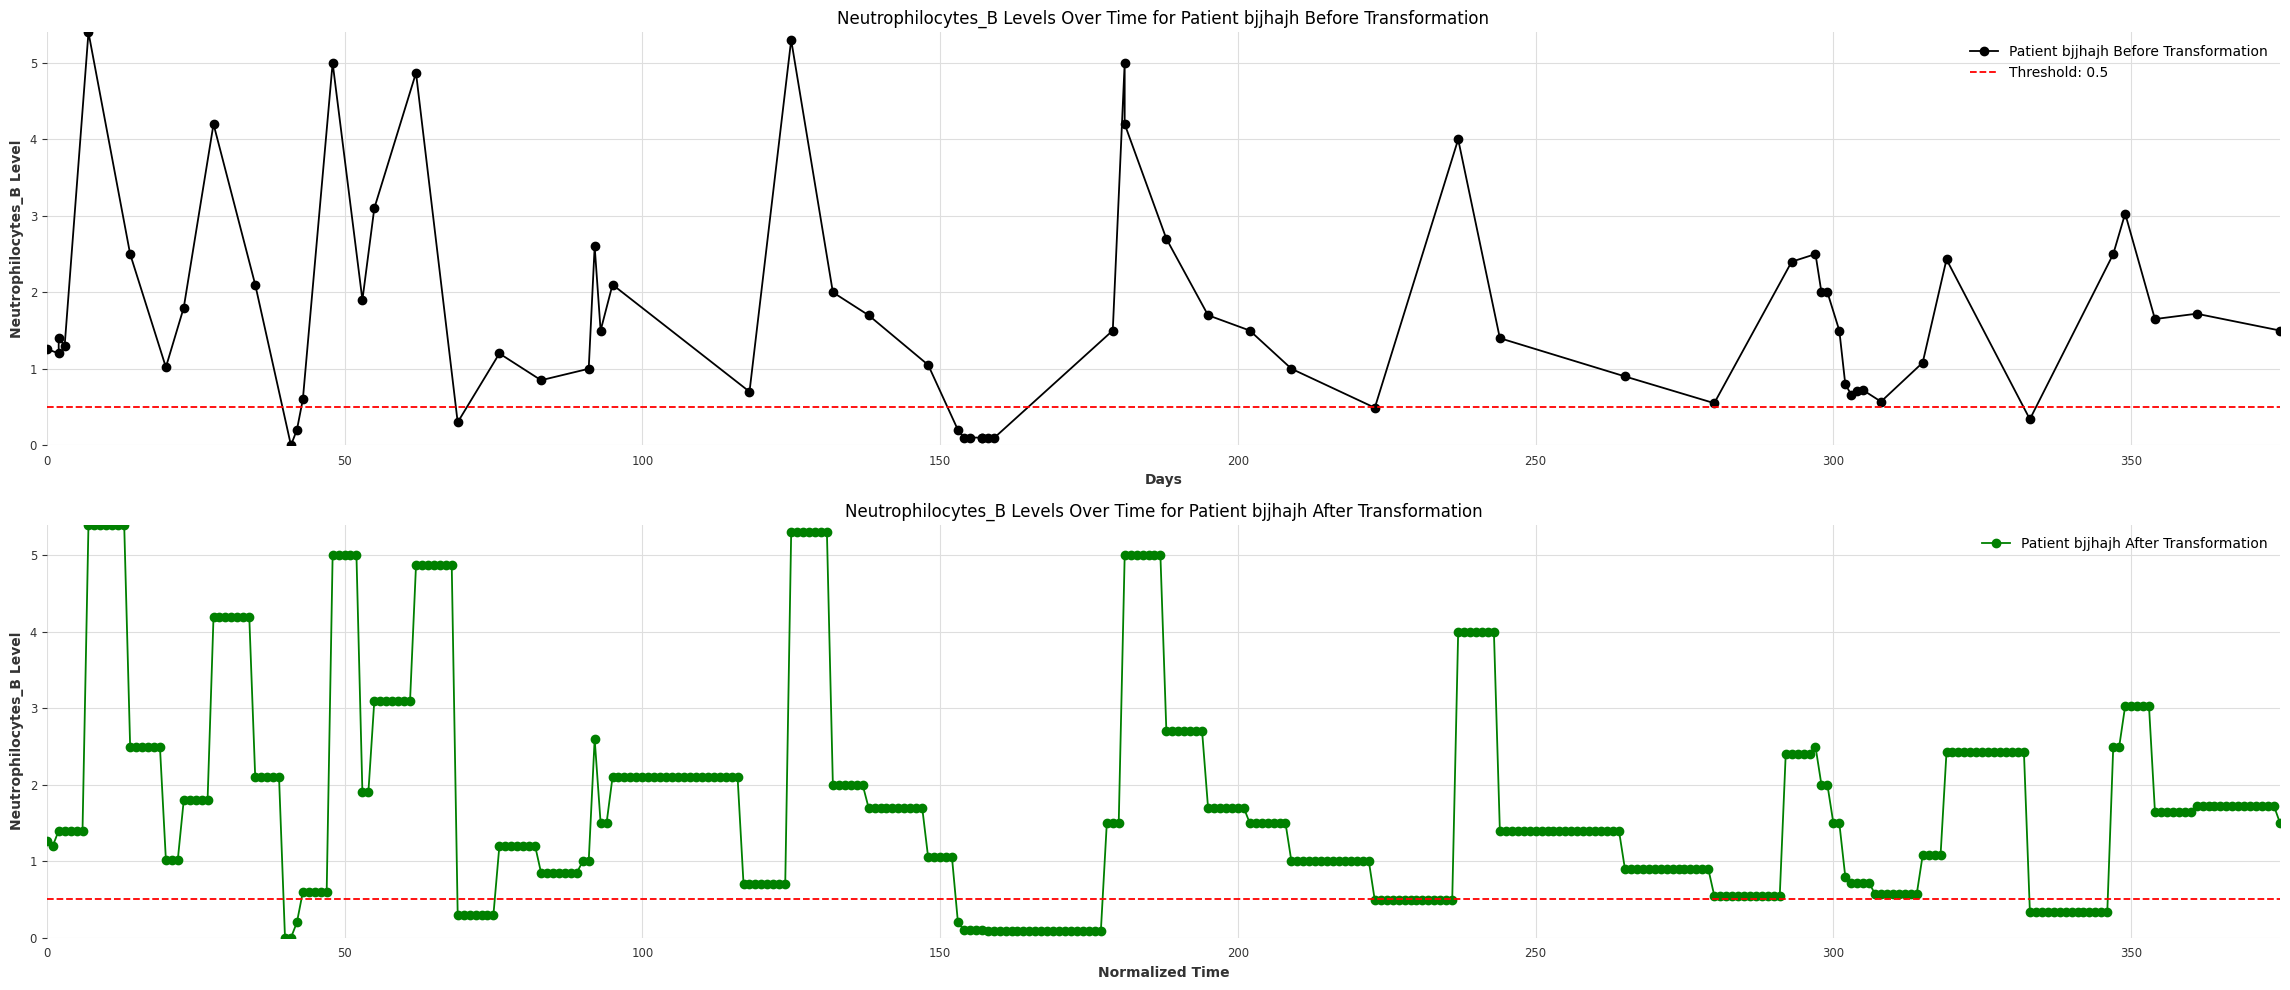

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is your original DataFrame and wide_df_complete_interpolated is the transformed DataFrame


# Function to filter patient data before transformation
def filterPatientANC(unique_id, component, df):
    data = df[
        (df["unique_id"] == unique_id) & (df["component"] == component)
    ].sort_values(by="days_since_first_infusion")
    return data


def filterPatientANC_transformed(unique_id, df):
    data = df[(df["unique_id"] == unique_id)]
    # Adjusted to directly use the 'Neutrophilocytes_B' column renamed to 'y' instead of a variable component name
    component_data = data[["normalized_time", "Neutrophilocytes_B"]].dropna()
    return component_data


# Replace 'bjjhajh' with the actual unique_id you're interested in
unique_id = "bjjhajh"  # Placeholder, replace with actual integer ID
component = "Neutrophilocytes_B"

# Filter data before and after transformation
data_org = filterPatientANC(unique_id, component, df)
data_transformed = filterPatientANC_transformed(unique_id, processed_df)

# Determine the common x and y limits
x_min = min(
    data_org["days_since_first_infusion"].min(),
    data_transformed["normalized_time"].min(),
)
x_max = max(
    data_org["days_since_first_infusion"].max(),
    data_transformed["normalized_time"].max(),
)
y_min = min(data_org["value"].min(), data_transformed["Neutrophilocytes_B"].min())
y_max = max(data_org["value"].max(), data_transformed["Neutrophilocytes_B"].max())

# Plotting
plt.figure(figsize=(23, 10))

# Plot before transformation
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(
    data_org["days_since_first_infusion"],
    data_org["value"],
    marker="o",
    linestyle="-",
    label=f"Patient {unique_id} Before Transformation",
)
plt.title(
    f"Neutrophilocytes_B Levels Over Time for Patient {unique_id} Before Transformation"
)
plt.axhline(y=0.5, color="r", linestyle="--", label="Threshold: 0.5")
plt.xlabel("Days")
plt.ylabel("Neutrophilocytes_B Level")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()

# Plot after transformation
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(
    data_transformed["normalized_time"],
    data_transformed["Neutrophilocytes_B"],
    marker="o",
    linestyle="-",
    color="green",
    label=f"Patient {unique_id} After Transformation",
)
plt.title(
    f"Neutrophilocytes_B Levels Over Time for Patient {unique_id} After Transformation"
)
plt.axhline(y=0.5, color="r", linestyle="--")
plt.xlabel("Normalized Time")
plt.ylabel("Neutrophilocytes_B Level")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
def test_decay_application(processed_df, df):
    missing_before = df.isna().sum().sum()
    missing_after = processed_df.isna().sum().sum()

    print(f"Missing values before transformation: {missing_before}")
    print(f"Missing values after transformation: {missing_after}")

    # Assuming decay models should reduce the number of missing values
    if missing_after < missing_before:
        print("Test passed: Decay models applied successfully.")
    else:
        print("Test failed: Decay models may not have been applied correctly.")


test_decay_application(processed_df, df)

Missing values before transformation: 0
Missing values after transformation: 154455
Test failed: Decay models may not have been applied correctly.


In [14]:
# Count the number of rows where all columns from the first to the last (excluding the first column) have NaN values
num_rows_all_nan = processed_df.iloc[:, 2:-1].isna().all(axis=1).sum()
print(
    f"Number of rows where all columns from components are NaN values: {num_rows_all_nan}"
)

Number of rows where all columns from components are NaN values: 0


In [15]:
processed_df.shape

(69071, 191)

In [16]:
# calculate the % of nan in each column
nan_percentages = processed_df.isna().mean() * 100
nan_percentages_top10 = nan_percentages.nlargest(10)
print("\nTop 10 columns with highest percentage of NaNs:")
print(nan_percentages_top10)


Top 10 columns with highest percentage of NaNs:
age                          74.539242
sex                          74.539242
infno                        74.539242
unique_id                     0.000000
normalized_time               0.000000
Alanine_transaminase_ALAT     0.000000
Albumin_P                     0.000000
Alkaline_phosphatase_P        0.000000
Amylase_P                     0.000000
Amylase_P_pancreatic_type     0.000000
dtype: float64


In [17]:
# Check if any columns with name in component_names have all 0 or non-unique values for each unique_id

# Check for errors in the DataFrame
def check_dataframe_errors(df):
    # Check for any infinite values
    if df.isin([np.inf, -np.inf]).any().any():
        print("Error: DataFrame contains infinite values.")
    else:
        print("No infinite values found in DataFrame.")
    
    # Check for any duplicate rows
    if df.duplicated().any():
        print("Error: DataFrame contains duplicate rows.")
    else:
        print("No duplicate rows found in DataFrame.")
    
    # Check for any columns with constant values (where min equals max)
    constant_columns = df.columns[(df.min() == df.max()).all()]
    if len(constant_columns) > 0:
        print(f"Error: DataFrame contains constant columns: {constant_columns.tolist()}")
    else:
        print("No constant columns found in DataFrame.")

# Call the function to check for errors
check_dataframe_errors(processed_df)

for col in component_list:
    if col in processed_df.columns:
        # Group by unique_id and check if the column has all 0 or non-unique values
        is_invalid = processed_df.groupby("unique_id")[col].apply(
            lambda x: x.eq(0).all() or x.nunique() == 1
        )

        if is_invalid.any():
            print(f"Column '{col}' has all 0 or non-unique values for some unique_ids.")
        # else:
        #     print(f"Column '{col}' has valid values for all unique_ids.")
    else:
        print(f"Column '{col}' not found in the DataFrame.")


Column 'Alkaline_phosphatase_P' has all 0 or non-unique values for some unique_ids.
Column 'Antitrombin_P' has all 0 or non-unique values for some unique_ids.
Column 'Basophilocytes_P' has all 0 or non-unique values for some unique_ids.
Column 'Bilirubin_P' has all 0 or non-unique values for some unique_ids.
Column 'Blast_cells_B' has all 0 or non-unique values for some unique_ids.
Column 'Calcium_ion' has all 0 or non-unique values for some unique_ids.
Column 'Carbamide_P' has all 0 or non-unique values for some unique_ids.
Column 'Coagulation_factor_II_VII_X_PP' has all 0 or non-unique values for some unique_ids.
Column 'Coagulation_surface_induced_APTT' has all 0 or non-unique values for some unique_ids.
Column 'Coagulation_tissue_factor_induced_INR' has all 0 or non-unique values for some unique_ids.
Column 'Fibrin_D_Dimer_P' has all 0 or non-unique values for some unique_ids.
Column 'Fibrinogen_P' has all 0 or non-unique values for some unique_ids.
Column 'Glucose_Csv' has all 0 o

In [18]:
# Verify that all unique_ids have continuous normalized_time steps
gaps = processed_df.groupby('unique_id')['normalized_time'].apply(lambda x: (x.diff() > 1).any())
if gaps.any():
    print("Gaps found in these IDs:", gaps[gaps].index.tolist())
else:
    print("No gaps in normalized time.")

No gaps in normalized time.


In [19]:
# Add a time_idx (an sequence of consecutive integers that goes from min to max date)

# if 'ds' not in processed_df.columns:
#     raise KeyError("Column 'ds' not found in the DataFrame.")

# data = (processed_df.merge((processed_df[['ds']].drop_duplicates(ignore_index=True)
# .rename_axis('time_idx')).reset_index(), on = ['ds']))

In [20]:
# Create a index 'range_index' with a RangeIndex for each patient
# processed_df = processed_df.set_index(
#     processed_df.groupby("unique_id")["normalized_time"]
#     .transform(lambda x: pd.RangeIndex(len(x)))
#     .rename("range_index")
# )
# assert "range_index" in processed_df.index.names

In [21]:
# print the min, mean and max length of range_index and normalized_time

# Get the length of each unique_id's data
# lengths = processed_df.groupby("unique_id").size()
# print(f"Range index lengths:")
# print(f"  Min: {lengths.min()}")
# print(f"  Mean: {lengths.mean():.2f}")
# print(f"  Max: {lengths.max()}")

# Get the min, mean, and max of normalized_time for each unique_id
normalized_time_stats = processed_df.groupby("unique_id")["normalized_time"].agg(
    ["min", "mean", "max"]
)

print(f"\nNormalized time ranges:")
print(
    f"  Min range: {normalized_time_stats['min'].min()} - {normalized_time_stats['max'].min()}"
)
print(
    f"  Mean range: {normalized_time_stats['min'].mean():.2f} - {normalized_time_stats['max'].mean():.2f}"
)
print(
    f"  Max range: {normalized_time_stats['min'].max()} - {normalized_time_stats['max'].max()}"
)


Normalized time ranges:
  Min range: 0 - 338
  Mean range: 0.00 - 378.45
  Max range: 0 - 444


In [22]:
processed_df.head()

,unique_id,normalized_time,age,sex,infno,Alanine_transaminase_ALAT,Albumin_P,Alkaline_phosphatase_P,Amylase_P,Amylase_P_pancreatic_type,...,Procalcitonin_PCT_delta,Promyelocytes_B_delta,Protein_cerebrospinal_fluid_CSF_delta,Reticulocytes_total_B_delta,Sodium_ion_P_delta,Thrombocytes_B_delta,Triacylglycerol_lipase_delta,Triglycerides_P_pt_fasting_status_unknown_delta,Urate_delta,eGFR_DSKB_DNS_2009_delta
0,bjaaaaa,0,15.0,2.0,1.0,238.0,32.0,82.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
1,bjaaaaa,1,15.0,2.0,1.0,140.0,32.0,82.0,0.0,0.0,...,1,1,1,1,2,2,1,1,1,1
2,bjaaaaa,2,15.0,2.0,1.0,147.0,30.0,71.0,0.0,0.0,...,1,1,1,1,2,2,1,1,1,1
3,bjaaaaa,3,NaN,NaN,NaN,147.0,30.0,71.0,0.0,0.0,...,1,1,1,1,3,3,1,1,1,1
4,bjaaaaa,4,NaN,NaN,NaN,147.0,30.0,71.0,0.0,0.0,...,1,1,1,1,3,3,1,1,1,1


### Read the 1. Defining static covariates
https://unit8co.github.io/darts/examples/15-static-covariates.html#

### remenber tide might not be good for this

### Set up the pytorch forecasting TFT using the masking - move along 



In [23]:
# Create a list of all column names except 'unique_id', 'sex', 'age', 'infno', and 'normalized_time'
excluded_columns = {'unique_id', 'sex', 'age', 'infno', 'normalized_time'}
component_names = [col for col in processed_df.columns if col not in excluded_columns]
print(f"Number of components: {len(component_names)}")



Number of components: 186


In [24]:
def test_static_columns(df, group_col, static_cols):
    for static_col in static_cols:
        unique_values_per_group = df.groupby(group_col)[static_col].nunique()
        if (unique_values_per_group != 1).any():
            raise ValueError(
                f"Static column '{static_col}' has multiple unique values within a group."
            )
    print("Static column test passed.")


# Usage
static_cols = ["sex", "age"]
test_static_columns(processed_df, "unique_id", static_cols)

Static column test passed.


In [25]:
processed_df.columns

Index(['unique_id', 'normalized_time', 'age', 'sex', 'infno',
       'Alanine_transaminase_ALAT', 'Albumin_P', 'Alkaline_phosphatase_P',
       'Amylase_P', 'Amylase_P_pancreatic_type',
       ...
       'Procalcitonin_PCT_delta', 'Promyelocytes_B_delta',
       'Protein_cerebrospinal_fluid_CSF_delta', 'Reticulocytes_total_B_delta',
       'Sodium_ion_P_delta', 'Thrombocytes_B_delta',
       'Triacylglycerol_lipase_delta',
       'Triglycerides_P_pt_fasting_status_unknown_delta', 'Urate_delta',
       'eGFR_DSKB_DNS_2009_delta'],
      dtype='object', length=191)

In [26]:
def split_data(unique_ids, test_size=0.2, random_state=42):
    train_ids, val_test_ids = train_test_split(unique_ids, test_size=test_size, random_state=random_state)
    val_ids, test_ids = train_test_split(val_test_ids, test_size=0.5, random_state=random_state)
    return train_ids, val_ids, test_ids

def create_time_series(patient_data, value_cols, static_covariates, freq):
    return TimeSeries.from_dataframe(
        patient_data,
        time_col="normalized_time",
        value_cols=value_cols,
        static_covariates=static_covariates,
        freq=freq
    )

def append_to_lists(unique_id, patient_data, component_names, static_covariates, data_lists):
    static_cov_df = pd.DataFrame([static_covariates], columns=static_covariates.index)

    # Ensure each patient data has a unique 'normalized_time' for time series creation
    patient_data = patient_data.copy()
    patient_data['normalized_time'] = range(len(patient_data))  # Reset the index to be unique per patient

    patient_series = create_time_series(
        patient_data.drop(columns=['infno']),
        component_names,
        static_cov_df,
        freq=1  # Assume daily frequency, adjust as needed
    )

    infno_series = create_time_series(
        patient_data[['normalized_time', 'infno']],
        ['infno'],
        static_cov_df,
        freq=1
    )

    list_type = 'train' if unique_id in train_ids else 'val' if unique_id in val_ids else 'test'
    main_list, covariates_list = data_lists[list_type]
    main_list.append(patient_series)
    covariates_list.append(infno_series)

def convert_to_float32(ts_lists, list_names):
    for ts_list, name in zip(ts_lists, list_names):
        ts_list[:] = [ts.astype(np.float32) for ts in ts_list]
        print(f"Length of {name}: {len(ts_list)}")

# Main execution block
unique_ids = processed_df["unique_id"].unique()
train_ids, val_ids, test_ids = split_data(unique_ids)

# Initialize lists for storing time series
train_list, val_list, test_list = [], [], []
train_covariates_list, val_covariates_list, test_covariates_list = [], [], []

data_lists = {
    'train': (train_list, train_covariates_list),
    'val': (val_list, val_covariates_list),
    'test': (test_list, test_covariates_list)
}

for unique_id in unique_ids:
    patient_data = processed_df[processed_df["unique_id"] == unique_id]
    static_covariates = patient_data[["sex", "age"]].iloc[0]
    append_to_lists(unique_id, patient_data, component_names, static_covariates, data_lists)

list_names = ["train_list", "val_list", "test_list", "train_covariates_list", "val_covariates_list", "test_covariates_list"]
convert_to_float32([train_list, val_list, test_list, train_covariates_list, val_covariates_list, test_covariates_list], list_names)

Length of train_list: 145
Length of val_list: 18
Length of test_list: 19
Length of train_covariates_list: 145
Length of val_covariates_list: 18
Length of test_covariates_list: 19


In [27]:
# Example check
print("Target Series Sample Data:", train_list[0].pd_dataframe().head())
print("Covariate Series Sample Data:", train_covariates_list[0].pd_dataframe().head())



Target Series Sample Data: component        Alanine_transaminase_ALAT  Albumin_P  Alkaline_phosphatase_P  \
normalized_time                                                                 
0                                    238.0       32.0                    82.0   
1                                    140.0       32.0                    82.0   
2                                    147.0       30.0                    71.0   
3                                    147.0       30.0                    71.0   
4                                    147.0       30.0                    71.0   

component        Amylase_P  Amylase_P_pancreatic_type  Antitrombin_P  \
normalized_time                                                        
0                      0.0                        0.0            0.0   
1                      0.0                        0.0            0.0   
2                      0.0                        0.0            0.0   
3                      0.0                   

<Axes: xlabel='normalized_time'>

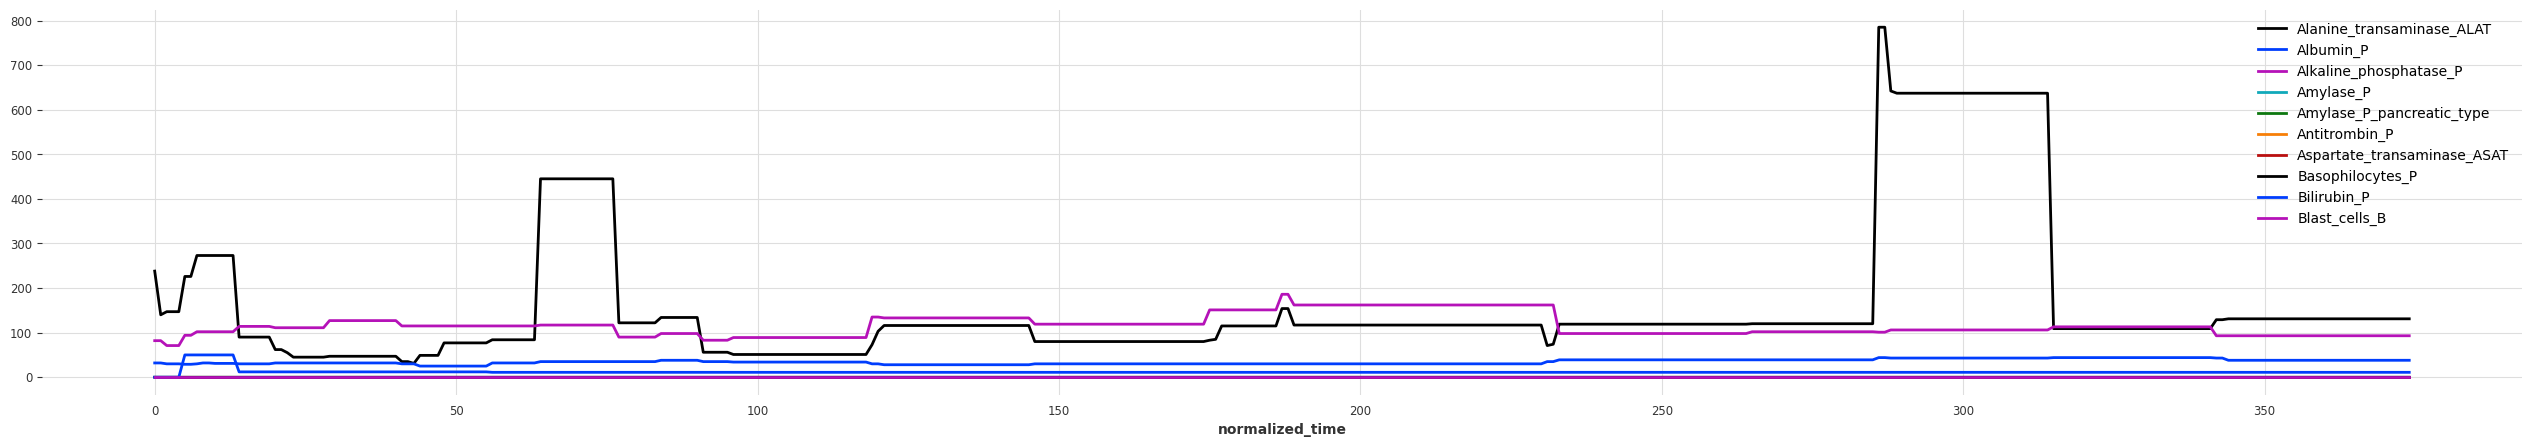

In [28]:
train_list[0].plot()

In [29]:
# from sklearn.model_selection import train_test_split

# # Create a list of unique patient IDs
# unique_ids = processed_df['unique_id'].unique()

# # Split the unique IDs into training, validation, and test sets
# train_ids, val_test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)
# val_ids, test_ids = train_test_split(val_test_ids, test_size=0.5, random_state=42)

# # Limit the number of patients in the training set to 20
# train_ids = train_ids[:20]

# # Assuming your DataFrame is named 'processed_df'
# train_series = TimeSeries.from_group_dataframe(
#        processed_df[processed_df['unique_id'].isin(train_ids)],
#        group_cols='unique_id',
#        time_col=None,
#        value_cols=component_names,
#        static_cols=['sex', 'age'],
#        freq=1
#    )

# val_series = TimeSeries.from_group_dataframe(
#     processed_df[processed_df['unique_id'].isin(val_ids)],
#     group_cols='unique_id',
#     time_col=None,
#     value_cols=component_names,
#     static_cols=['sex', 'age'],
#     freq=1
# )

# test_series = TimeSeries.from_group_dataframe(
#     processed_df[processed_df['unique_id'].isin(test_ids)],
#     group_cols='unique_id',
#     time_col=None,
#     value_cols=component_names,
#     static_cols=['sex', 'age'],
#     freq=1
# )

# # Convert the TimeSeries objects to float32
# train_list = [ts.astype(np.float32) for ts in train_series]
# val_list = [ts.astype(np.float32) for ts in val_series]
# test_list = [ts.astype(np.float32) for ts in test_series]

# print(f"Length of train_list: {len(train_list)}")
# print(f"Length of val_list: {len(val_list)}")
# print(f"Length of test_list: {len(test_list)}")

In [30]:
train_list[0].head()

<TimeSeries (DataArray) (normalized_time: 5, component: 186, sample: 1)> Size: 4kB
array([[[2.380e+02],
        [3.200e+01],
        [8.200e+01],
        [0.000e+00],
        [0.000e+00],
        [0.000e+00],
        [0.000e+00],
        [2.000e-02],
        [0.000e+00],
        [0.000e+00],
        [0.000e+00],
        [0.000e+00],
        [0.000e+00],
        [0.000e+00],
        [5.500e+00],
        [0.000e+00],
        [0.000e+00],
        [0.000e+00],
        [0.000e+00],
        [0.000e+00],
...
        [1.000e+00],
        [1.000e+00],
        [1.000e+00],
        [4.000e+00],
        [3.000e+00],
        [1.000e+00],
        [3.000e+00],
        [1.000e+00],
        [1.000e+00],
        [3.000e+00],
        [1.000e+00],
        [1.000e+00],
        [1.000e+00],
        [1.000e+00],
        [3.000e+00],
        [3.000e+00],
        [1.000e+00],
        [1.000e+00],
        [1.000e+00],
        [1.000e+00]]], dtype=float32)
Coordinates:
  * normalized_time  (normalized_time) int64 40B 0 1 2 3 4
  * component        (component) object 1kB 'Alanine_transaminase_ALAT' ... '...
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  sex   age\nglobal_components  2.0 ...
    hierarchy:          None

In [31]:
# Count the number of rows in each list
train_rows = sum(len(ts) for ts in train_list)
val_rows = sum(len(ts) for ts in val_list)
test_rows = sum(len(ts) for ts in test_list)

# Calculate the total number of rows
total_rows = train_rows + val_rows + test_rows

print(f"Number of rows in train_list: {train_rows}")
print(f"Number of rows in val_list: {val_rows}")
print(f"Number of rows in test_list: {test_rows}")
print(f"Total number of rows: {total_rows}")

Number of rows in train_list: 54802
Number of rows in val_list: 6983
Number of rows in test_list: 7286
Total number of rows: 69071


In [32]:
# Check the number of rows with NaN values in each column
nan_rows_per_column = processed_df.isna().sum()

# Count the total number of rows with at least one NaN value
total_nan_rows = processed_df.isna().any(axis=1).sum()

print(f"Number of rows with NaN values per column:\n{nan_rows_per_column}")
print(f"\nTotal number of rows with at least one NaN value: {total_nan_rows}")

Number of rows with NaN values per column:
unique_id                                              0
normalized_time                                        0
age                                                51485
sex                                                51485
infno                                              51485
                                                   ...  
Thrombocytes_B_delta                                   0
Triacylglycerol_lipase_delta                           0
Triglycerides_P_pt_fasting_status_unknown_delta        0
Urate_delta                                            0
eGFR_DSKB_DNS_2009_delta                               0
Length: 191, dtype: int64

Total number of rows with at least one NaN value: 51485


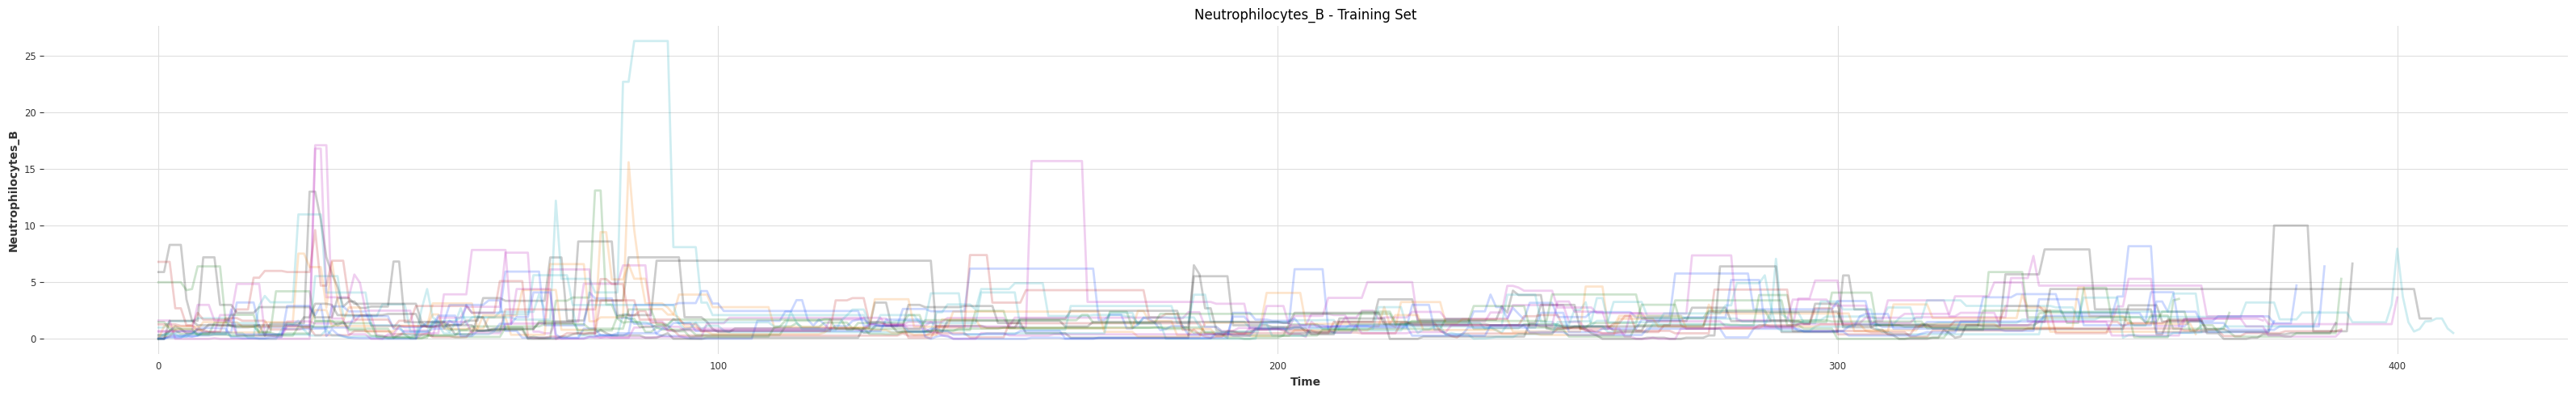

In [33]:
# Choose a component to plot
component_to_plot = "Neutrophilocytes_B"

# Plot the chosen component for the training set
fig, ax = plt.subplots(1, 1, figsize=fig_size)
for train_series in test_list:
    train_series[component_to_plot].plot(ax=ax, label="_nolegend_", alpha=0.2)
ax.set_xlabel("Time")
ax.set_ylabel(component_to_plot)
ax.set_title(f"{component_to_plot} - Training Set")
plt.tight_layout()
plt.show()

In [34]:
# Scale the series
# scaler = Scaler()
# train_scaled = scaler.fit_transform(train_list)
# val_scaled = scaler.transform(val_list)
# test_scaled = scaler.transform(test_list)

# Working
# for train_series, val_series in zip(train_scaled, val_scaled):
#     model = TiDEModel(
#     input_chunk_length = 40 ,# Specifies the length of the input chunk, which is the number of time steps fed into the model at each time step.
#     output_chunk_length = 10, #Specifies the length of the output chunk
#     num_encoder_layers = 2, #Specifies the number of layers in the encoder.
#     num_decoder_layers = 2, # Specifies the number of layers in the decoder.
#     decoder_output_dim = 30, #Specifies the output dimension of the decoder.
#     hidden_size = 512, #Specifies the size of the hidden layers.
#     temporal_decoder_hidden = 32, #Specifies the size of the hidden layers in the temporal decoder.
#     use_layer_norm = True, #Specifies whether to use layer normalization.
#     dropout = 0.9, #Specifies the dropout probability.
#     random_state = 42, #Specifies the random state for reproducibility
#     use_static_covariates=True,
#     use_reversible_instance_norm=True,
#     )

#     model.fit(series=train_scaled, val_series=val_scaled, epochs=5, verbose=True)

In [35]:
# # Get predictions for a specific patient
# patient_id = 'bjaaaaa'  # Specify the unique_id of the patient you want to get predictions for

# patient_data = processed_df[processed_df['unique_id'] == patient_id]
# patient_static_covariates = patient_data[['sex', 'age']].iloc[0]

# # Select the desired components
# selected_components = ['Leukocytes_B', 'Neutrophilocytes_B', 'Aspartate_transaminase_ASAT', 'Alanine_transaminase_ALAT', 'Creatininium_P']

# patient_series = TimeSeries.from_dataframe(
#     patient_data,
#     time_col=None,
#     value_cols=component_names,
#     static_covariates=patient_static_covariates,
#     freq=1
# )

# patient_scaled = scaler.transform(patient_series)

# # Convert the data to float32
# patient_scaled = patient_scaled.astype(np.float32)

# # Specify the day for which you want to get the actual values
# day = 50

# # Specify the number of days before and after the specified day to plot
# days_before = 10
# days_after = 36

# # Get the actual values for the specified range of days
# actual_values = patient_series[day-days_before:day+days_after]

# # Get the scaled patient series up to the specified day
# patient_scaled_up_to_day = patient_scaled[:day+1]

# # Predict the next 36 values starting from the specified day
# patient_pred_scaled = model.predict(n=36, series=patient_scaled_up_to_day)
# patient_pred = scaler.inverse_transform(patient_pred_scaled)

# # Select the desired components from the actual values and predictions using indexing
# actual_values = actual_values[selected_components]
# patient_pred = patient_pred[selected_components]

# # Create subplots for each component
# fig, axes = plt.subplots(len(selected_components), 1, figsize=(12, 6*len(selected_components)), sharex=True)

# for i, component in enumerate(selected_components):
#     ax = axes[i]
#     actual_values[component].plot(label="Actual", ax=ax)
#     patient_pred[component].plot(label="Predicted", ax=ax)
#     ax.axvline(x=days_before, color='red', linestyle='--', label='Prediction Start')
#     ax.set_ylabel(component)
#     ax.legend()

# axes[-1].set_xlabel("Time")
# fig.suptitle(f"Actual and Predicted Values for Patient {patient_id}\nPrediction Start: Day {day}")
# plt.tight_layout()
# plt.show()

In [36]:
# Check the number of features and samples in each dataset
print("Training Target Width:", train_list[0].width)
print("Validation Target Width:", val_list[0].width)
print(
    "Training Covariates Width:",
    train_covariates_list[0].width if train_covariates_list else "None",
)
print(
    "Validation Covariates Width:",
    val_covariates_list[0].width if val_covariates_list else "None",
)

Training Target Width: 186
Validation Target Width: 186
Training Covariates Width: 1
Validation Covariates Width: 1


In [37]:
# # Read data
# series = AirPassengersDataset().load().astype(np.float32)

# # we convert monthly number of passengers to average daily number of passengers per month
# series = series / TimeSeries.from_series(series.time_index.days_in_month)
# series = series.astype(np.float32)

# # Create training and validation sets:
# training_cutoff = pd.Timestamp("19571201")
# train, val = series.split_after(training_cutoff)

In [38]:
# Scale the main series
scaler_main = Scaler()
train_scaled = [scaler_main.fit_transform(ts) for ts in train_list]
val_scaled = [scaler_main.transform(ts) for ts in val_list]
test_scaled = [scaler_main.transform(ts) for ts in test_list]

# Assuming you might want to scale covariates as well
scaler_covariates = Scaler()
train_covariates_scaled = [scaler_covariates.fit_transform(ts) for ts in train_covariates_list]
val_covariates_scaled = [scaler_covariates.transform(ts) for ts in val_covariates_list]
test_covariates_scaled = [scaler_covariates.transform(ts) for ts in test_covariates_list]

# Update the lists in your data_lists dictionary
data_lists = {
    'train': (train_scaled, train_covariates_scaled),
    'val': (val_scaled, val_covariates_scaled),
    'test': (test_scaled, test_covariates_scaled)
}

In [39]:
# # Initialize scalers for main series and covariates
# scaler_main = Scaler()
# scaler_covariates = Scaler()

# # Prepare lists to store scaled data
# train_scaled = []
# val_scaled = []
# train_covariates_scaled = []
# val_covariates_scaled = []

# # Scale the main series
# for series in train_list:
#     train_scaled.append(scaler_main.fit_transform(series))
# for series in val_list:
#     val_scaled.append(scaler_main.transform(series))

# # Scale the covariates
# for covariate in train_covariates_list:
#     train_covariates_scaled.append(scaler_covariates.fit_transform(covariate))
# for covariate in val_covariates_list:
#     val_covariates_scaled.append(scaler_covariates.transform(covariate))

# # Check the first scaled series and covariates
# print("Scaled Main Series Sample:", train_scaled[0].pd_dataframe().describe())
# print("Scaled Covariates Sample:", train_covariates_scaled[0].pd_dataframe().describe())


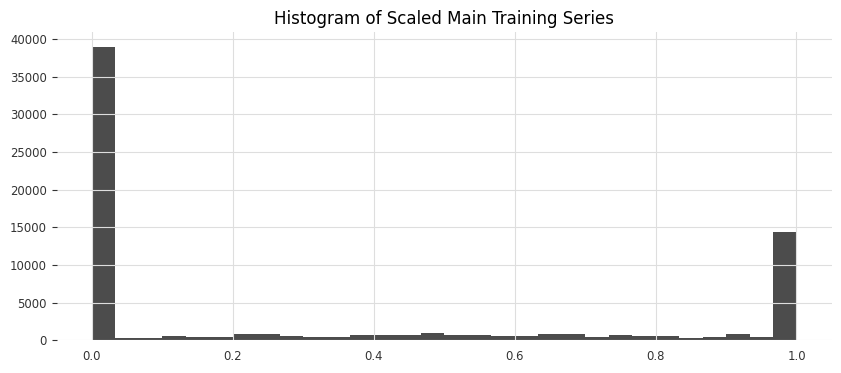

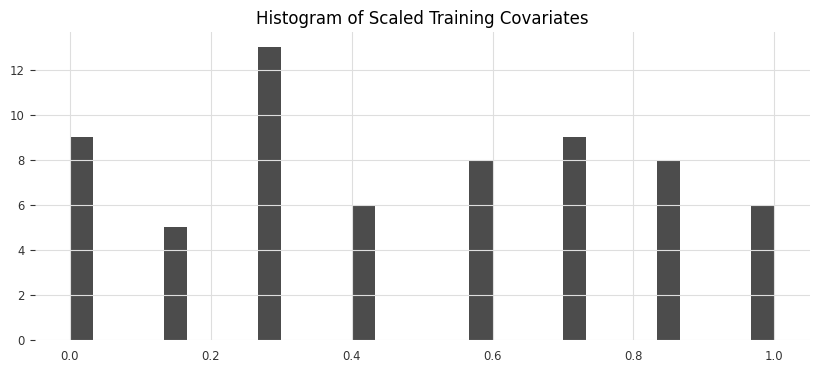

In [40]:
import matplotlib.pyplot as plt


def plot_scaled_data(series, title=""):
    plt.figure(figsize=(10, 4))
    plt.hist(series.values().flatten(), bins=30, alpha=0.7)
    plt.title(title)
    plt.grid(True)
    plt.show()

# Assuming 'train_scaled' and 'train_covariates_scaled' are lists of TimeSeries objects
plot_scaled_data(train_scaled[0], title="Histogram of Scaled Main Training Series")
plot_scaled_data(train_covariates_scaled[0], title="Histogram of Scaled Training Covariates")


In [41]:
# Import necessary modules from Darts
from darts.metrics import msse
from darts.models import TSMixerModel


# print some optimization trials information
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

def validate_predictions(val_list, val_preds):
    if len(val_list) != len(val_preds):
        print(f"Validation mismatch: {len(val_list)} actual vs {len(val_preds)} predictions")
        return float('inf')
    
    scores = []
    for i, (actual, pred) in enumerate(zip(val_list, val_preds)):
        if not actual.has_same_time_as(pred):
            print(f"Time index mismatch at position {i}:")
            print("Actual indices:", actual.time_index)
            print("Prediction indices:", pred.time_index)
            continue
        
        try:
            score = msse(actual, pred)
            scores.append(score)
        except Exception as e:
            print(f"Error processing pair at index {i} with error: {str(e)}")
            print("Actual values:", actual.values())
            print("Predicted values:", pred.values())
    
    if scores:
        average_score = np.mean(scores)
        print("Average MSSE:", average_score)
        return average_score
    else:
        print("No valid scores calculated.")
        return float('inf')
    

# Define the objective function for hyperparameter tuning
def objective(trial):
    # Suggest values for the hyperparameters specific to TSMixerModel
    hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128, 256])
    dropout = trial.suggest_float("dropout", 0.1, 0.7, step=0.1)
    ff_size = trial.suggest_categorical("ff_size", [32, 64, 128, 256])
    optimizer_kwargs = {"lr": trial.suggest_float("lr", 0.00001, 0.002, log=True)}
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256, 512])

    pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    early_stopper = EarlyStopping(
        "val_loss", min_delta=0.001, patience=5, mode="min", verbose=True
    )
    callback = [pruner, early_stopper]
    # Model and trainer configurations
    pl_trainer_kwargs = {
        "max_epochs": 50,
        "accelerator": "auto",
        "callbacks": callback,
    }

    # Instantiate and fit the model using scaled data
    model = TSMixerModel(
        input_chunk_length=40,
        output_chunk_length=8,
        hidden_size=hidden_size,
        ff_size=ff_size,
        dropout=dropout,
        optimizer_kwargs=optimizer_kwargs,
        pl_trainer_kwargs=pl_trainer_kwargs,
        batch_size=batch_size,
        random_state=42
    )
    model.fit(
        series=train_scaled,  # Use scaled training data
        past_covariates=train_covariates_scaled,  # Use scaled training covariates
        val_series=val_scaled,  # Use scaled validation data
        val_past_covariates=val_covariates_scaled,  # Use scaled validation covariates
        verbose=True,
    )

    val_preds = model.predict(
        n=8,  # Ensure this matches the number of actual validation points you have
        series=val_scaled,  # Use scaled validation data
        past_covariates=val_covariates_scaled,  # Use scaled validation covariates
        verbose=True
    )
    # Now, val_preds should have the same length as val_list, and you can validate them accordingly
    average_msse = validate_predictions(val_list, val_preds)
    print("Computed Average MSSE:", average_msse)
    return average_msse

# Create a study object and optimize the objective function
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, callbacks=[print_callback])

print("Number of trials:", len(study.trials))
if study.best_trial:
    print("Best trial:")
    print("  Value:", study.best_trial.value)
    print("  Params:")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]
Time index mismatch at position 0:
Actual indices: RangeIndex(start=0, stop=346, step=1, name='normalized_time')
Prediction indices: RangeIndex(start=346, stop=354, step=1, name='normalized_time')
Time index mismatch at position 1:
Actual indices: RangeIndex(start=0, stop=424, step=1, name='normalized_time')
Prediction indices: RangeIndex(start=424, stop=432, step=1, name='normalized_time')
Time index mismatch at position 2:
Actual indices: RangeIndex(start=0, stop=439, step=1, name='normalized_time')
Prediction indices: RangeIndex(start=439, stop=447, step=1, name='normalized_time')
Time index mismatch at position 3:
Actual indices: RangeIndex(start=0, stop=390, step=1, name='normalized_time')
Prediction indices: RangeIndex(start=390, stop=398, step=1, name='normalized_time')
Time index mismatch at position 4:
Actual indices: RangeIndex(start=0, stop=366, step=1, name='normalized_time')
Prediction indices: RangeInd

In [ ]:
def custom_smape(actual, forecast) -> float:
    actual = np.array(actual)
    forecast = np.array(forecast)
    min_length = min(len(actual), len(forecast))
    actual = actual[:min_length]
    forecast = forecast[:min_length]
    numerator = np.abs(forecast - actual)
    denominator = np.abs(actual) + np.abs(forecast)
    safe_denominator = np.where(denominator == 0, 1, denominator)  # prevent division by zero
    ratio = numerator / safe_denominator
    smape = 200 * np.mean(ratio)
    return smape


# print some optimization trials information
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


# define objective function
def objective(trial):
    # Suggest values for the hyperparameters
    decoder_output_dim = trial.suggest_int("decoder_output_dim", 8, 64, step=10)
    hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128, 256])
    dropout = trial.suggest_float("dropout", 0.1, 0.7, step=0.1)
    output_chunk_shift = trial.suggest_int("output_chunk_shift", 1, 7)
    num_encoder_layers = trial.suggest_int("num_encoder_layers", 1, 3)
    num_decoder_layers = trial.suggest_int("num_decoder_layers", 1, 3)
    optimizer_kwargs = {"lr": trial.suggest_float("lr", 0.00001, 0.002, log=True)}
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256, 512])
    gradient_clip_val = trial.suggest_float("gradient_clip_val", 0.5, 1.0, step=0.1)

    pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    early_stopper = EarlyStopping(
        "val_loss", min_delta=0.001, patience=5, mode="min", verbose=True
    )
    callback = [pruner, early_stopper]

    # Model and trainer configurations
    # optimizer_kwargs = {"lr": 1e-5}
    pl_trainer_kwargs = {
        "gradient_clip_val": gradient_clip_val,
        "max_epochs": 50,
        "accelerator": "auto",
        "callbacks": callback,
    }
    lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
    lr_scheduler_kwargs = {"gamma": 0.999}

    # Common model arguments
    common_model_args = {
        "input_chunk_length": 40,
        "output_chunk_length": 10,
        "decoder_output_dim": decoder_output_dim,
        "output_chunk_shift": output_chunk_shift,
        "num_encoder_layers": num_encoder_layers,
        "num_decoder_layers": num_decoder_layers,
        "hidden_size": hidden_size,
        "dropout": dropout,
        "optimizer_kwargs": optimizer_kwargs,
        "pl_trainer_kwargs": pl_trainer_kwargs,
        "lr_scheduler_cls": lr_scheduler_cls,
        "lr_scheduler_kwargs": lr_scheduler_kwargs,
        "likelihood": None,
        "save_checkpoints": True,
        "force_reset": True,
        "random_state": 42,
        "batch_size": batch_size,
    }

    # Instantiate and fit the model
    model = TiDEModel(
        **common_model_args,
        use_reversible_instance_norm=True,
        use_static_covariates=True,
    )
    # Instantiate and fit the model using scaled data
    model.fit(
        series=train_scaled,  # Use scaled training data
        past_covariates=train_covariates_scaled,  # Use scaled training covariates
        val_series=val_scaled,  # Use scaled validation data
        val_past_covariates=val_covariates_scaled,  # Use scaled validation covariates
        verbose=True,
    )

    # Predict using scaled validation data and covariates
    val_preds = model.predict(
        n=6,
        series=val_scaled,  # Use scaled validation data
        past_covariates=val_covariates_scaled,  # Use scaled validation covariates
        verbose=True
    )


    scores = []
    for idx, val_pred in enumerate(val_preds):
        # Use the main scaler to inversely transform the predictions
        val_pred_unscaled = scaler_main.inverse_transform(val_pred)

        # Correctly retrieve the actual data from the validation set, ensuring it's the unscaled version
        actual = val_list[idx]

        # If actual data is scaled, it needs to be inversely transformed using the same scaler used for scaling it
        actual_unscaled = scaler_main.inverse_transform(actual)

        # Calculate the SMAPE score using the unscaled data
        score = custom_smape(
            actual_unscaled.pd_dataframe().values, 
            val_pred_unscaled.pd_dataframe().values
        )
        scores.append(score)

    # Calculate average SMAPE across all predictions
    return np.mean(scores)  # Use average SMAPE as the optimization objective


# Create a study object and optimize the objective function
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=120, callbacks=[print_callback])


print("Number of trials:", len(study.trials))
if study.best_trial:
    print("Best trial:")
    print("  Value:", study.best_trial.value)
    print("  Params:")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")

In [ ]:
# Print the best hyperparameters found by optimization
print("Best hyperparameters:")
for model_name, params in trial.items():
    print(f"{model_name}:")
    for param, value in params.items():
        print(f"  {param}: {value}")
    print()

# Print the best scores achieved by each model
print("Best scores:")
for model_name, score in trial.items():
    print(f"{model_name}: {score}")

In [ ]:
# This code iterates over the best hyperparameters found for each model
for model_name, params in trial.items():
    # Remove the EarlyStopping callback from the params dictionary
    if "pl_trainer_kwargs" in params and "callbacks" in params["pl_trainer_kwargs"]:
        params["pl_trainer_kwargs"]["callbacks"] = [
            TFMProgressBar(enable_train_bar_only=True)
        ]

for model_name, params in trial.items():
    model = TiDEModel(use_reversible_instance_norm=(model_name == "TiDE+RIN"), **params)
    model.fit(series=train_scaled, val_series=val_scaled, verbose=True)
    model_save_path = f"best_{model_name}_model.pth"
    model.save(model_save_path)
    print(f"Saved {model_name} model to {model_save_path}")

# Evaluate the best models on the test dataset
for model_name, _ in trial.items():
    # Load the saved model from the file
    model_save_path = f"best_{model_name}_model.pth"
    loaded_model = TiDEModel.load(model_save_path)
    test_pred = loaded_model.predict(n=len(test_scaled))
    reversed_pred = scaler.inverse_transform(test_pred)
    reversed_test = scaler.inverse_transform(test_scaled)
    # Calculate the Mean Absolute Error (MAE) and Mean Squared Error (MSE)
    test_mae = mae(reversed_test, reversed_pred)
    test_mse = mse(reversed_test, reversed_pred)

    # Print the evaluation metrics for each model
    print(f"{model_name} - Test MAE: {test_mae}, Test MSE: {test_mse}")

In [ ]:
# Assuming you have already run the hyperparameter_tuning function and obtained best_models
models = best_models

# predict the next `pred_steps` points after the end of `pred_input`
pred_steps = common_model_args["output_chunk_length"] * 2
pred_input = test[:-pred_steps]

fig, ax = plt.subplots(figsize=(fig_size))
pred_input.plot(label="input")
test[-pred_steps:].plot(label="ground truth", ax=ax)

result_accumulator = {}
# predict with each model and compute/store the metrics against the test sets
for model_name, model in models.items():
    pred_series = model.predict(n=pred_steps, series=pred_input, verbose=True)
    pred_series.plot(label=model_name, ax=ax)

    result_accumulator[model_name] = {
        "mae": mae(test, pred_series),
        "mse": mse(test, pred_series),
    }

In [ ]:
results_df = pd.DataFrame.from_dict(result_accumulator, orient="index")
results_df.plot.bar()

In [ ]:
# before starting, we define some constants
num_samples = 200

figsize = (32, 5)  # wide figures
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

In [ ]:
# Read data
series = AirPassengersDataset().load()

# we convert monthly number of passengers to average daily number of passengers per month
series = series / TimeSeries.from_series(series.time_index.days_in_month)
series = series.astype(np.float32)

# Create training and validation sets:
training_cutoff = pd.Timestamp("19571201")
train, val = series.split_after(training_cutoff)

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(series, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)

# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

In [ ]:
# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
input_chunk_length = 40
forecast_horizon = 10
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=300,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
    use_static_covariates=True,
)

In [ ]:
my_model.fit(test_list, verbose=True)

In [ ]:
def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=num_samples)

    # plot actual series
    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    plt.title("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    plt.legend()


eval_model(my_model, 24, series_transformed, val_transformed)